In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from dotenv import load_dotenv
import os


pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
def read_data(path):
    return pd.read_csv(path)
load_dotenv() 
data_path = os.getenv("TRAINING_DATA")
df = read_data(data_path)

In [12]:
"""
Split the dataset into features and target, then divide it into training and testing sets.

- X: feature matrix (all columns except the target)
- y: target variable ('HATSURESI')
- 90% of the data is used for training, 10% for testing
- The random_state ensures reproducible results
"""

# Separate features (X) and target variable (y)
X = df.drop(["HATSURESI","Unnamed: 0", "Unnamed: 0.1"], axis=1)  
y = df["HATSURESI"]                 # Target variable to predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the resulting splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((154851, 31), (38713, 31), (154851,), (38713,))

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

In [14]:
"""
Define the CatBoost model using optimized hyperparameters:

learning_rate: step size for updates

l2_leaf_reg: L2 regularization on leaf values

iterations: total number of boosting rounds

depth: depth of each tree

border_count: number of splits for numerical features

verbose=0: suppress training output

random_state: ensures reproducibility
"""

cat_model = CatBoostRegressor(
    learning_rate=0.1,
    l2_leaf_reg=9,
    iterations=500,
    depth=10,
    border_count=64,
    verbose=0,
    random_state=42
)


In [15]:
"""
Evaluate model performance using 5-fold cross-validation:

KFold: splits data into 5 folds with shuffling

cross_val_score: evaluates R² score across folds

Mean R² score gives a robust estimate of model generalization
"""
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(cat_model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)

print("📊 5-Fold Cross-Validation R² Scores:", np.round(cv_scores, 4))
print("📈 Mean CV R² Score:", np.round(np.mean(cv_scores), 4))

📊 5-Fold Cross-Validation R² Scores: [0.7027 0.7071 0.699  0.7004 0.6985]
📈 Mean CV R² Score: 0.7015


In [16]:
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

r2_cat = r2_score(y_test, y_pred_cat)
rmse_cat = mean_squared_error(y_test, y_pred_cat) ** 0.5 
mae_cat = mean_absolute_error(y_test, y_pred_cat)
mape_cat = np.mean(np.abs((y_test - y_pred_cat) / y_test.replace(0, 1e-10))) * 100

print("\n🐱 Final CatBoost Test Set Results:")
print(f"R² Score: {r2_cat:.4f}")
print(f"RMSE: {rmse_cat:.2f}")
print(f"MAE: {mae_cat:.2f}")
print(f"MAPE: {mape_cat:.2f}%")



🐱 Final CatBoost Test Set Results:
R² Score: 0.7023
RMSE: 6.42
MAE: 4.21
MAPE: 6.97%


In [17]:
"""
Extract and display feature importances:

Shows how much each feature contributed to the model's predictions

Sorted from most to least important
"""

importances = cat_model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n📌 Feature Importances (sorted):")
print(importance_df)


📌 Feature Importances (sorted):
                               Feature  Importance
26                     HATSURESI_LAG_1   32.617408
1                                 HOUR   16.659524
28                     HATSURESI_LAG_3   10.129365
27                     HATSURESI_LAG_2    9.352824
29                     HATSURESI_LAG_4    8.363996
30                     HATSURESI_LAG_5    6.287763
0                         weather_temp    3.973180
20         PANDEMIC_CONDITION_Pandemic    2.417740
7                        DAY_OF_WEEK_6    1.527928
6                        DAY_OF_WEEK_5    1.333126
21           SCHOOL_STATUS_School Open    1.114908
22          weather_description_Cloudy    1.055059
12                             MONTH_5    0.482318
5                        DAY_OF_WEEK_4    0.460401
8              HOLIDAY_CATEGORY_Normal    0.437076
4                        DAY_OF_WEEK_3    0.351362
18                            MONTH_11    0.333636
11                             MONTH_4    0.31682

C:\Users\Excalibur\AppData\Local\Temp\ipykernel_23940\4008664096.py:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Excalibur\Desktop\Bitirme Projesi\Datas\800-last\IE-4912\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


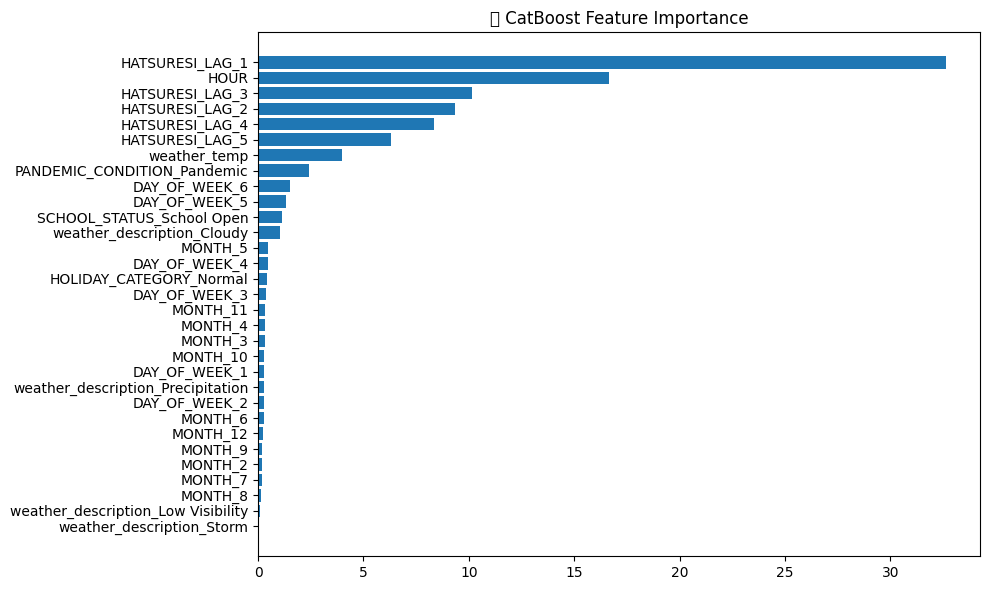

In [18]:
"""
Visualize the feature importance rankings:

Horizontal bar plot showing top features

Helps identify which features have the greatest predictive power
"""
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("🎯 CatBoost Feature Importance")
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()